# Dropping of sparse columns

The main goal of this notebook is to deal with missing values in the dataset, that forbid us to perform most of machine learning algorithms.

We'll first import the database and get rid of some columns that only contain one value (thus providing no information whatsoever).
We'll then drop columns that present more than 65% missing values (the threshold of 65% being chosen so that genetic variables, with a missing values ratio of 64%, are not overlooked).

## Libraries imports

In [ ]:
# Basic imports
import pandas as pd
import numpy as np

# Import to find the wave related to each variable
import re

# Imports to impute missing values
from sklearn.impute import SimpleImputer
import scipy

import matplotlib.pyplot as plt
import seaborn as sns

## Data import

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/data_without_AE.csv")

<ipython-input-2-9a43259a351d>:1: DtypeWarning: Columns (1379,1380,1382,1388,1391,15103) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("/content/drive/MyDrive/data_without_AE.csv")


In [ ]:
data.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42233 entries, 0 to 42232
Columns: 15104 entries, HHIDPN to genetic_Section_A_or_E
dtypes: float64(14977), int64(111), object(16)
memory usage: 4.8 GB


In [ ]:
data.head()

,HHIDPN,S1HHIDPN,R1MSTAT,R1MPART,S1BMONTH,S1BYEAR,S1BDATE,S1BFLAG,S1COHBYR,S1HRSAMP,...,genetic_4_PP_COGENT17,genetic_4_SBP_COGENT17,genetic_4_EGFR_CKDGEN19,genetic_4_EGFRTE_CKDGEN19,genetic_4_EA3_W23_SSGAC18,genetic_4_HBA1CAA_MAGIC17,genetic_4_HBA1CEA_MAGIC17,genetic_4_GCOG2_CHARGE18,genetic_VERSION,genetic_Section_A_or_E
0,1010,0.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010,0.0,7.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3010,3020.0,1.0,0.0,9.0,1938.0,-7778.0,0.0,3.0,1.0,...,-0.58662,-0.66936,1.04423,1.02390,1.53372,0.47688,-1.28083,-1.51568,4.3,E
3,3020,3010.0,1.0,0.0,1.0,1936.0,-8752.0,0.0,3.0,1.0,...,-0.06204,-0.70205,-1.06050,-1.08282,0.85439,-0.62488,-1.29031,0.40118,4.3,E
4,10001010,0.0,8.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Drop columns with more than 65% of missing values

If we happened to just count the number of missing values in each row without any further consideration, we would miss the fact that some values are missing not because they were not recorded, but because it would make no sense for them to be.

To avoid this problem, we will check, when a value is missing, if the respondant had been interviewed during the considered wage or not: if he hasn't been interviewed, then we don't take the related missing values in consideration.

In [ ]:
# We check how many wages are available in the database.
for col in data.columns:
  if "INW" in col:
    print(col, end=" ; ")

INW1 ; INW2 ; INW3 ; INW4 ; INW5 ; INW6 ; INW7 ; INW8 ; INW9 ; INW10 ; INW11 ; INW12 ; INW13 ; INW14 ; 

wave 1: 743 ; overall: 743
wave 2: 965 ; overall: 1708
wave 3: 974 ; overall: 2682
wave 4: 1042 ; overall: 3724
wave 5: 1032 ; overall: 4756
wave 6: 1069 ; overall: 5825
wave 7: 1074 ; overall: 6899
wave 8: 1123 ; overall: 8022
wave 9: 1133 ; overall: 9155
wave 10: 1169 ; overall: 10324
wave 11: 1162 ; overall: 11486
wave 12: 1144 ; overall: 12630
wave 13: 1172 ; overall: 13802
wave 14: 1153 ; overall: 14955


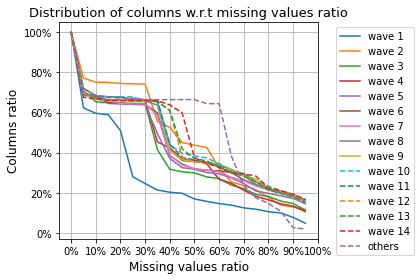

In [ ]:
# To explore with more details the number of columns with a given missing values rate, we will plot the associated curve.
def count_columns(missing_values_thresholds, data):
  """
  Return a numpy array with, for each threshold, the number of columns in 'data'
  that present a missing values rate greater than 'threshold'
  """
  array_of_counts = np.zeros(len(thresholds))

  for i in range(len(thresholds)):
    threshold = thresholds[i]

    # We look for columns with a missing values rate greater than 'threshold'.
    criteria = data.isna().sum()/data.shape[0] >= threshold # This criteria is True for columns with too much missing values.
    array_of_counts[i] += len(criteria.index[criteria])
  
  return array_of_counts

thresholds = np.arange(0, 1, 0.05)
columns_distribution = np.zeros(len(thresholds))

regex = re.compile("[0-9]+")

# First, we proceed for each waves-related variables
number_of_such_variables = 0
for wave in range(1, 15):
  # We collect all columns related to current wave.
  wave_columns = [col for col in data.columns if len(regex.findall(col)) != 0 and regex.findall(col)[0] == str(wave)]
  wave_data = data.loc[data[f"INW{wave}"] == 1, wave_columns]

  # We now evaluate the distribution of columns for each threshold.
  columns_distribution_for_this_wave = count_columns(thresholds, wave_data)
  columns_distribution += columns_distribution_for_this_wave

  # Then we plot it.
  plt.plot(thresholds, columns_distribution_for_this_wave/columns_distribution_for_this_wave[0], label=f"wave {wave}", ls="-"*(wave//10+1))

  # This is pure verbose.
  number_of_such_variables += wave_data.shape[1]
  print(f"wave {wave}: {wave_data.shape[1]} ; overall: {number_of_such_variables}")

# Second, we proceed for all the other variables.
columns_of_interest = [col for col in data.columns if len(regex.findall(col)) == 0]
data_of_interest = data[columns_of_interest]

# We now evaluate the distribution of columns for each threshold.
columns_distribution_for_these_data = count_columns(thresholds, data_of_interest)
columns_distribution += columns_distribution_for_these_data

# Then we plot it.
plt.plot(thresholds, columns_distribution_for_these_data/columns_distribution_for_these_data[0], label="others", ls = "--")

plt.xticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], [f"{x*10}%" for x in range(0, 11)])
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], [f"{x*20}%" for x in range(0, 6)])

plt.xlabel("Missing values ratio", fontsize=12)
plt.ylabel("Columns ratio", fontsize=12)
plt.title("Distribution of columns w.r.t missing values ratio", fontsize=13)

plt.legend(bbox_to_anchor=(1.05, 1.0))
plt.tight_layout()

plt.grid()
plt.show() 

The graph above is meant to be interpreted like this: among the variables collected from the interviews in wave 1, 60% of them present more than 10% missing values.

Overall, every waves present an identical distribution.
The one curve that distinguishes itself is the 'others' curve: it looks like the number of columns of this category which present a missing values ratio between 60% and 70% behave differently. This can be explained by the fact that genetic data only concerns 36% of individuals, so it presents a missing values ratio of 64% (see the code below).

In [ ]:
print("Genetic data concerns {}% of the individuals.".format(100 - (data["genetic_Section_A_or_E"].isna().sum()/data.shape[0]).round(4)*100))

Genetic data concerns 35.97% of the individuals.


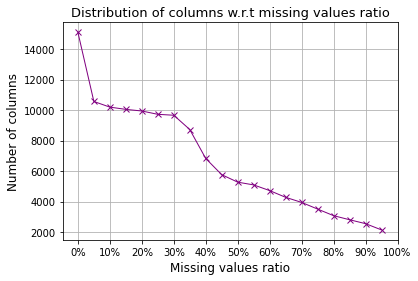

In [ ]:
plt.plot(thresholds, columns_distribution, marker="x", ls="-", lw = '1', color="purple")

plt.xticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], [f"{x*10}%" for x in range(0, 11)])

plt.xlabel("Missing values ratio", fontsize=12)
plt.ylabel("Number of columns", fontsize=12)
plt.title("Distribution of columns w.r.t missing values ratio", fontsize=13)

plt.grid()
plt.show()

This graph highlights that our database presents many missing values. To conserve genetic data, we decide to drop all columns with a missing values ration greater than 65%. It will erase about 4000 columns.

In [ ]:
max_missing_values_rate = 0.65

In [ ]:
def columns_to_delete(threshold, data):
  """
  Return a copy of the 'data' where columns with a missing_values_rate greater than threshold
  have been deleted.
  """
  # We look for columns with a missing values rate greater than 'threshold'.
  criteria = data.isna().sum()/data.shape[0] >= threshold # This criteria is True for columns with too much missing values.
  
  return list(criteria.index(criteria))


regex = re.compile("[0-9]+")
columns_to_delete = []

# First, we proceed for each waves-related variables.
for wave in range(1, 15):
  print(wave, end= " ; ")
  # We collect all columns related to current wave.
  wave_columns = [col for col in data.columns if len(regex.findall(col)) != 0 and regex.findall(col)[0] == str(wave)]
  wave_data = data.loc[data[f"INW{wave}"] == 1, wave_columns]

  # We identify columns to delete for this specific wave.
  criteria = wave_data.isna().sum()/wave_data.shape[0] >= max_missing_values_rate
  columns_to_delete += list(criteria.index[criteria])

# Second, we proceed for all the other variables.
columns_of_interest = [col for col in data.columns if len(regex.findall(col)) == 0]
data_of_interest = data[columns_of_interest]

criteria = data_of_interest.isna().sum()/data_of_interest.shape[0] >= max_missing_values_rate
columns_to_delete += list(criteria.index[criteria])

1 ; 2 ; 3 ; 4 ; 5 ; 6 ; 7 ; 8 ; 9 ; 10 ; 11 ; 12 ; 13 ; 14 ; 

In [ ]:
print("Before drop, data shape =", data.shape)
data.info(memory_usage="deep")

Before drop, data shape = (42233, 15104)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42233 entries, 0 to 42232
Columns: 15104 entries, HHIDPN to genetic_Section_A_or_E
dtypes: float64(14977), int64(111), object(16)
memory usage: 4.8 GB


In [ ]:
# Finally, we drop these columns
data = data.drop(columns=columns_to_delete)

print("After drop, data shape =", data.shape)
print(data.info(memory_usage="deep"))

After drop, data shape = (42233, 10825)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42233 entries, 0 to 42232
Columns: 10825 entries, HHIDPN to genetic_Section_A_or_E
dtypes: float64(10698), int64(111), object(16)
memory usage: 3.4+ GB
None


In [ ]:
15104 - 10825

4279

We successfully dropped 15104  - 10825 = 4279 columns.

The next step is to cast right dtypes: too many columns have been casted as float64.

## Cast dtypes

In [ ]:
data.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42233 entries, 0 to 42232
Columns: 10825 entries, HHIDPN to genetic_Section_A_or_E
dtypes: float64(10698), int64(111), object(16)
memory usage: 3.4 GB


### Object dtypes

Only 16 columns have been casted as 'object'. Let us deal with them.

In [ ]:
data.select_dtypes(include=["object"]).head()

,H1HHIDC,H2HHIDC,H3HHIDC,H4HHIDC,H5HHIDC,H6HHIDC,H7HHIDC,H8HHIDC,H9HHIDC,H10HHIDC,H11HHIDC,H12HHIDC,H13HHIDC,H14HHIDC,FILEVER,genetic_Section_A_or_E
0,0000010,0000010,.,.,.,.,.,.,.,.,.,.,.,.,U,NaN
1,0000020,0000020,0000020,0000020,0000020,.,.,.,.,.,.,.,.,.,U,NaN
2,0000030,0000030,0000030,0000030,0000030,0000030,0000030,0000030,0000030,0000030,0000030,.,.,.,U,E
3,0000030,0000030,0000030,0000030,0000030,0000030,0000030,0000030,0000030,0000030,0000030,0000030,.,.,U,E
4,0100010,0100010,0100010,0100010,0100010,0100010,0100010,0100010,0100010,0100010,0100010,0100010,0100010,.,U,NaN


In [ ]:
data["genetic_Section_A_or_E"] = data["genetic_Section_A_or_E"].astype("category") # this variable only takes 'A' and 'E' as values.
data = data.drop("FILEVER", axis=1) # this variable does not give information (each row is 'U')
for i in range(1, 15):
  col = f"H{i}HHIDC"
  data[col] = data[col].replace("      .", np.nan).astype("float64") # We get rid of the '      .'.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42233 entries, 0 to 42232
Columns: 10824 entries, HHIDPN to genetic_Section_A_or_E
dtypes: category(1), float64(10712), int64(111)
memory usage: 3.4 GB


### Int dtypes

In [ ]:
data.select_dtypes(include=["int64"]).columns

Index(['HHIDPN', 'INW1', 'INW2', 'INW3', 'INW4', 'INW5', 'INW6', 'INW7',
       'INW8', 'INW9',
       ...
       'R5IADL5H', 'R6IADL5H', 'R7IADL5H', 'R8IADL5H', 'R9IADL5H', 'R10IADL5H',
       'R11IADL5H', 'R12IADL5H', 'R13IADL5H', 'R14IADL5H'],
      dtype='object', length=111)

In [ ]:
data.select_dtypes(include=["int64"]).isna().sum().max()

0

As we could have guessed, there is no particular problems with these columns.

### Float dtypes

In [ ]:
data_unique = data.nunique()/data.count()

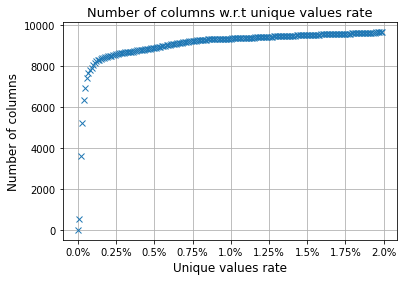

In [ ]:
number_of_classes = np.arange(0, 2, 0.01)
percentages = []
for n in number_of_classes:
  percentages.append((data_unique<=n/100).sum())

plt.plot(number_of_classes, percentages, 'x')

x_ticks = [0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0]
plt.xticks(x_ticks, [f"{x}%" for x in x_ticks])

plt.xlabel("Unique values rate", fontsize=12)
plt.ylabel("Number of columns", fontsize=12)
plt.title("Number of columns w.r.t unique values rate", fontsize=13)

plt.grid()
plt.show()

This graph let us reckon that the most majority of columns present categorical variables (as of the low number of different values).

For future exploration of our database, we need to be aware of the type of each column. One may try to infer it with respect to the number of unique values each column take, and although this approach might prove itself right most of the time, it would cast numeric data to categorical ones or the other way around without any way for us to be informed of that. Hence, we will need to find another way to proceed. This will be the subject of the next notebook.

## Save the database

In [ ]:
data.to_csv("first_drop_data.csv", index=False)